In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.datasets import make_circles
import pandas as pd
import numpy as np

from pathlib import Path 

from helper_functions import plot_predictions, plot_decision_boundary

# 1. Creating Toy dataset


This dataset will contain a dot and respective color in inner and outer circle. We have to predict with the coordinate if the dot is in outer or inner circle

In [2]:
X, y = make_circles(n_samples=1000, noise=0.04, random_state=42)

In [3]:
pandas_dataframe = pd.DataFrame({'X1': X[:, 0], 'X2': X[:, 1], 'labels': y})
pandas_dataframe.head(10)

,X1,X2,labels
0,0.748227,0.239083,1
1,-0.745096,0.160975,1
2,-0.822625,0.197621,1
3,-0.411433,0.682556,1
4,0.443905,-0.895829,0
5,-0.474766,0.692236,1
6,-0.014847,0.804486,1
7,0.765568,0.153643,1
8,-0.172507,-0.796646,1
9,-0.116051,1.031858,0


<Axes: xlabel='X1', ylabel='X2'>

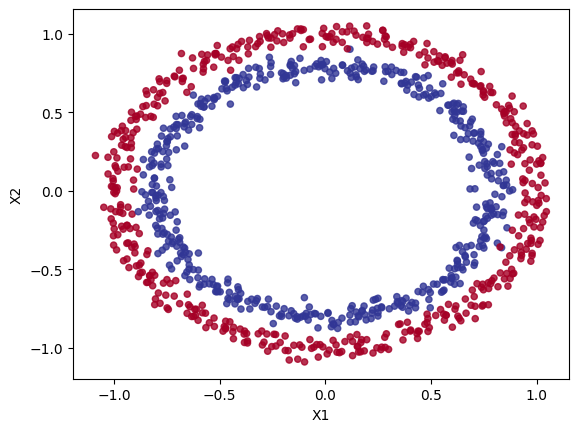

In [4]:
# Visualize with a plot
pandas_dataframe.plot(kind='scatter', x='X1', y='X2', c='labels', alpha= 0.8, colormap=plt.cm.RdYlBu, colorbar=False)

## Preprocessing

Converting our data into tenosrs so that we can apply torch methods

In [5]:
X = torch.from_numpy(pandas_dataframe[['X1','X2']].to_numpy())
y = torch.from_numpy(pandas_dataframe['labels'].to_numpy())
X = X.type(torch.float)
y = y.type(torch.float)

creating train,test split

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #Sklearn accepts torch tensors

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

creating device agnostic code and constructing model

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
model_0 = nn.Sequential(
    nn.Linear(2, 5),
    nn.Linear(5, 1),
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Accuracy Function

In [9]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

### 3. Training

In [10]:
def train(model, X_train, X_test, y_train, y_test, return_losses:bool = True,epochs= 1000):
    torch.manual_seed(42)

    # Optimizer and Loss Function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Adam optimizer, optimizer like SGD but more efficient.
    loss_fn = nn.BCEWithLogitsLoss() # Binary cross entropy loss with a sigmoid layer for classification tasks
    
    losses = np.array([])
    for epoch in range (epochs):
        model.train()

        y_logits = model(X_train).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_train, y_pred)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        model.eval()
        with torch.inference_mode():
      # 1. Forward pass
            test_logits = model(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)
            loss = loss.detach().cpu().numpy()
            losses = np.append(losses, loss)
    # Print out what's happening
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")
            print(y_logits.shape, y_train.shape)
    if return_losses:
        return losses
    

In [11]:
losses = train(model_0, X_train, X_test, y_train, y_test, epochs=100)

Epoch: 0 | Loss: 0.73170, Accuracy: 50.00% | Test Loss: 0.71351, Test Accuracy: 50.00%
torch.Size([800]) torch.Size([800])
Epoch: 10 | Loss: 0.69915, Accuracy: 50.00% | Test Loss: 0.69460, Test Accuracy: 50.00%
torch.Size([800]) torch.Size([800])
Epoch: 20 | Loss: 0.69301, Accuracy: 50.25% | Test Loss: 0.69516, Test Accuracy: 47.00%
torch.Size([800]) torch.Size([800])
Epoch: 30 | Loss: 0.69381, Accuracy: 47.00% | Test Loss: 0.69707, Test Accuracy: 46.00%
torch.Size([800]) torch.Size([800])
Epoch: 40 | Loss: 0.69305, Accuracy: 50.62% | Test Loss: 0.69533, Test Accuracy: 45.50%
torch.Size([800]) torch.Size([800])
Epoch: 50 | Loss: 0.69305, Accuracy: 53.00% | Test Loss: 0.69449, Test Accuracy: 48.50%
torch.Size([800]) torch.Size([800])
Epoch: 60 | Loss: 0.69300, Accuracy: 52.00% | Test Loss: 0.69433, Test Accuracy: 46.50%
torch.Size([800]) torch.Size([800])
Epoch: 70 | Loss: 0.69299, Accuracy: 50.38% | Test Loss: 0.69462, Test Accuracy: 46.00%
torch.Size([800]) torch.Size([800])
Epoch: 80

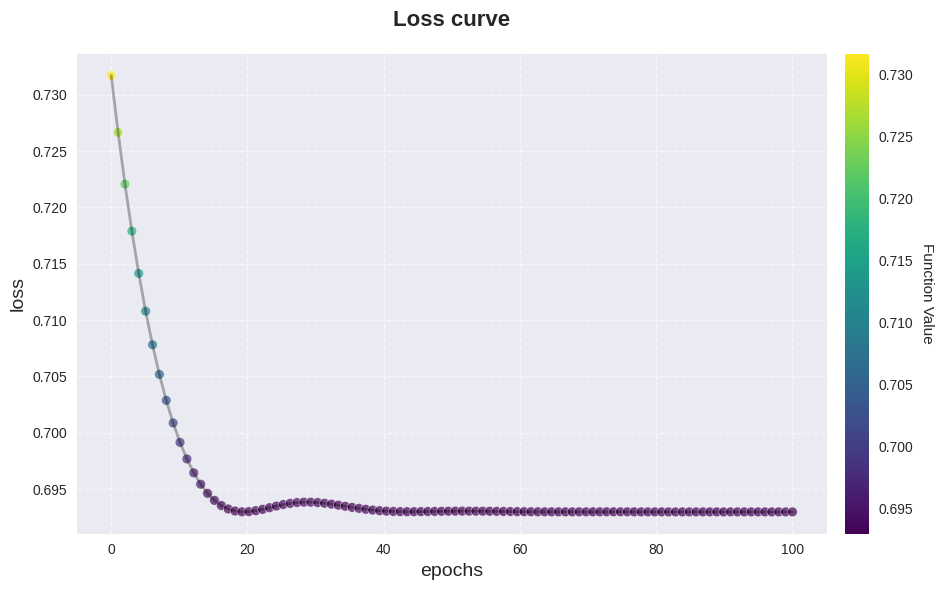

In [12]:
from helper_functions import plot_functions

plt.show(plot_functions(losses, title="Loss curve", xlabel="epochs", ylabel="loss", x_range=(0,100)))

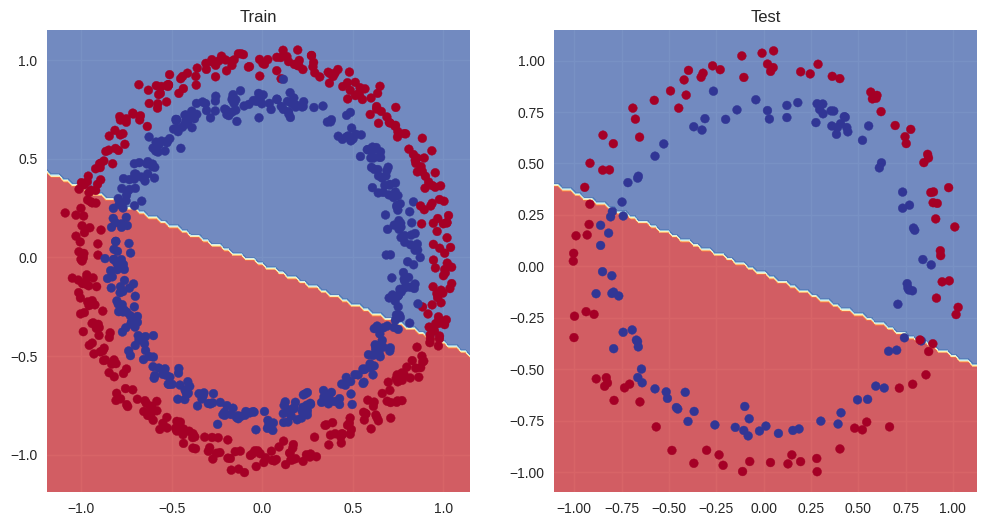

In [21]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Using non linear activation for non linear data. Model2

In [23]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_1 = CircleModelV2().to(device)
print(model_1)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [24]:
losses = train(model_1, X_train, X_test, y_train, y_test, epochs=300)

Epoch: 0 | Loss: 0.69440, Accuracy: 50.00% | Test Loss: 0.69277, Test Accuracy: 50.00%
torch.Size([800]) torch.Size([800])
Epoch: 10 | Loss: 0.68935, Accuracy: 51.00% | Test Loss: 0.68613, Test Accuracy: 53.50%
torch.Size([800]) torch.Size([800])
Epoch: 20 | Loss: 0.68278, Accuracy: 52.50% | Test Loss: 0.67756, Test Accuracy: 57.50%
torch.Size([800]) torch.Size([800])
Epoch: 30 | Loss: 0.66836, Accuracy: 63.00% | Test Loss: 0.66557, Test Accuracy: 65.50%
torch.Size([800]) torch.Size([800])
Epoch: 40 | Loss: 0.64222, Accuracy: 66.75% | Test Loss: 0.65022, Test Accuracy: 66.50%
torch.Size([800]) torch.Size([800])
Epoch: 50 | Loss: 0.60173, Accuracy: 71.25% | Test Loss: 0.62283, Test Accuracy: 69.00%
torch.Size([800]) torch.Size([800])
Epoch: 60 | Loss: 0.54155, Accuracy: 76.50% | Test Loss: 0.56556, Test Accuracy: 75.00%
torch.Size([800]) torch.Size([800])
Epoch: 70 | Loss: 0.45933, Accuracy: 89.50% | Test Loss: 0.48790, Test Accuracy: 83.00%
torch.Size([800]) torch.Size([800])
Epoch: 80

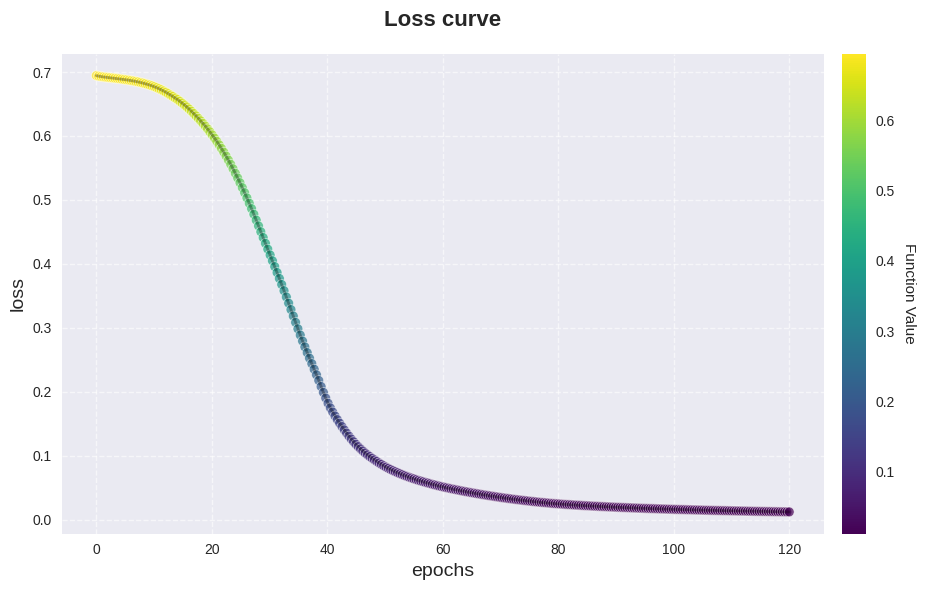

In [25]:
plt.show(plot_functions(losses, title="Loss curve", xlabel="epochs", ylabel="loss", x_range=(0,120)))

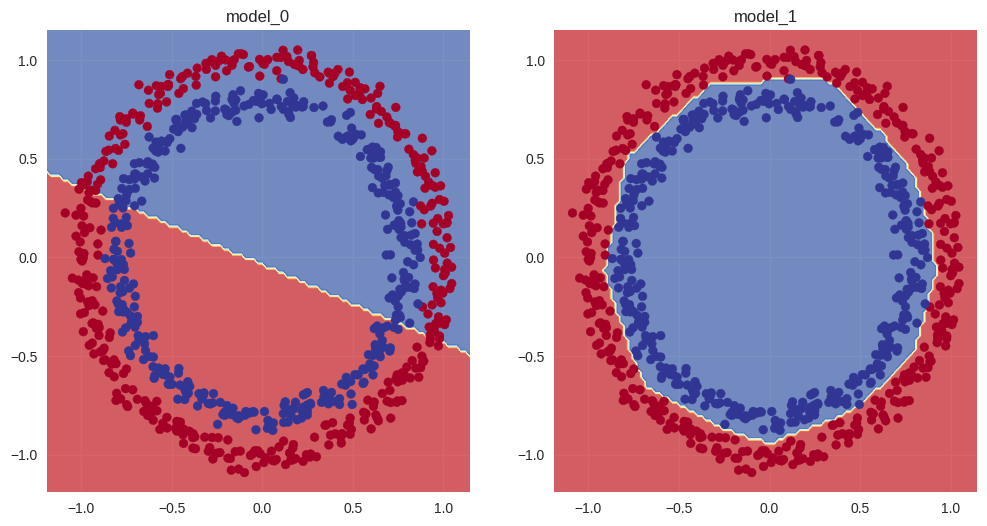

In [26]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("model_0")
plot_decision_boundary(model_0, X_train, y_train) # model_0 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("model_1")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = has non-linearity

In [18]:
model_2 = nn.Sequential(   
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
).to(device)

In [19]:
losses = train(model_2, X_train, X_test, y_train, y_test, epochs=1000)

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69209, Test Accuracy: 55.50%
torch.Size([800]) torch.Size([800])
Epoch: 10 | Loss: 0.68650, Accuracy: 53.62% | Test Loss: 0.68434, Test Accuracy: 57.00%
torch.Size([800]) torch.Size([800])
Epoch: 20 | Loss: 0.67718, Accuracy: 54.25% | Test Loss: 0.67219, Test Accuracy: 57.00%
torch.Size([800]) torch.Size([800])
Epoch: 30 | Loss: 0.66111, Accuracy: 61.25% | Test Loss: 0.65446, Test Accuracy: 63.50%
torch.Size([800]) torch.Size([800])
Epoch: 40 | Loss: 0.63298, Accuracy: 66.12% | Test Loss: 0.62736, Test Accuracy: 70.50%
torch.Size([800]) torch.Size([800])
Epoch: 50 | Loss: 0.58827, Accuracy: 75.88% | Test Loss: 0.58294, Test Accuracy: 75.50%
torch.Size([800]) torch.Size([800])
Epoch: 60 | Loss: 0.52397, Accuracy: 81.12% | Test Loss: 0.54027, Test Accuracy: 77.50%
torch.Size([800]) torch.Size([800])
Epoch: 70 | Loss: 0.44430, Accuracy: 89.12% | Test Loss: 0.47384, Test Accuracy: 83.50%
torch.Size([800]) torch.Size([800])
Epoch: 80

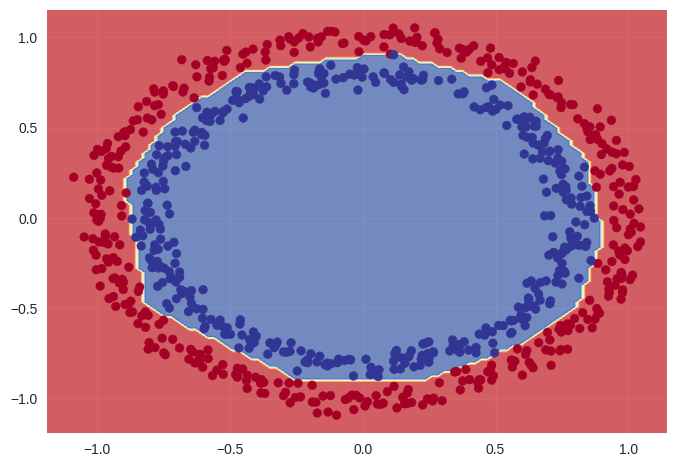

In [20]:
plot_decision_boundary(model_2, X_train, y_train) # model_2 = has non-linearity